In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans 

## Exploration of features that could be included (with small dataset)

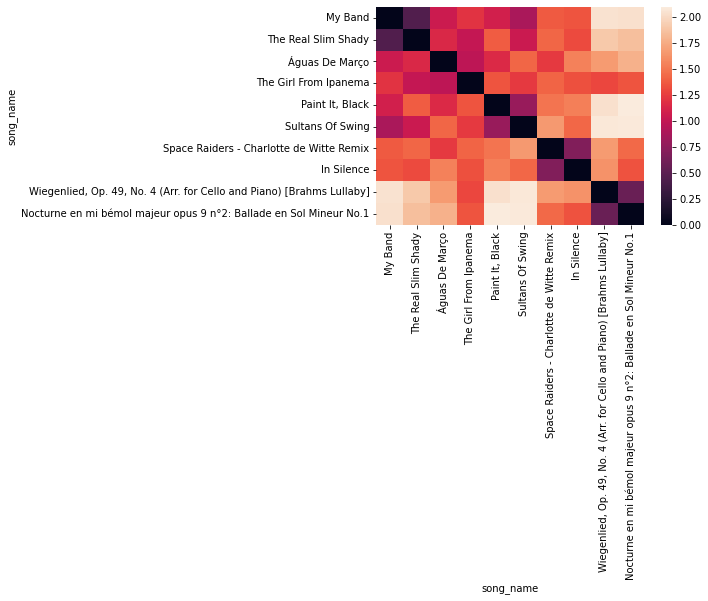

In [2]:
# import data
audio_features = pd.read_csv('data/df_audio_features_10.csv')

# choose columns to include in the model
relevant_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo']
features_only = audio_features[relevant_cols]

# initialize transformer to scale data to [0, 1]
min_max_scaler = MinMaxScaler(feature_range= (0, 1))
min_max_scaler.fit(features_only)
features_only_scaled = min_max_scaler.transform(features_only)

features_only_scaled = pd.DataFrame(features_only_scaled,
                                    index= audio_features.song_name,
                                    columns= features_only.columns)

# compute pairwise distances between songs
euclidian_distances = pd.DataFrame(pairwise_distances(features_only_scaled), index= audio_features.song_name, columns= audio_features.song_name)

# visualize pairwise distances in heatmap
sns.heatmap(euclidian_distances);

## Choosing variables to include and importing data

In [3]:
# import data
features_big = pd.read_csv('data/df_audio_features_5000.csv')
features_big.columns = features_big.columns.str.strip()
features_big.name = features_big.name.str.strip()
features_big = features_big.drop_duplicates(subset=['name', 'artist'])

In [4]:
features_big.columns

Index(['name', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'duration_ms', 'time_signature', 'id',
       'html'],
      dtype='object')

In [5]:
# choose columns to include in the model (removed = key, mode, type, duration_ms, liveness, loudness)
cols = ['danceability', 'energy', 'speechiness', 'acousticness', 
        'instrumentalness', 'valence', 'tempo']

features_only = features_big[cols]

## Exploration of different scaling methods (big dataset)

### Range scaling

In [6]:
def range_scaler(col, min_value, max_value): 
    min_col = min_value
    max_col = max_value
    norm_val = []
    for val in col:
        norm_val.append((val - min_col) / (max_col - min_col))
    return norm_val

var_ranges = {'danceability': (0,1), 'energy': (0,1), 'key': (-1,11), 'loudness': (-60,0),
       'speechiness': (0,1), 'acousticness': (0,1), 'instrumentalness': (0,1), 'liveness': (0,1),
       'valence': (0,1)}

def range_scale_df(df):
    
    cols = df.columns
    scaled_cols = {}

    for col in cols:
        if col in var_ranges.keys():
            scaled_cols[col] = range_scaler(df[col], var_ranges[col][0], var_ranges[col][1])
        else:
            min_max_scaler = MinMaxScaler(feature_range= (0, 1))
            min_max_scaler.fit(df[[col]])
            scaled_cols[col] = list(min_max_scaler.transform(df[[col]]))
    
    features_only_range_scaled = pd.DataFrame(scaled_cols)
    return features_only_range_scaled

In [7]:
# apply scaling to data
range_scaled = range_scale_df(features_only)
range_scaled.set_index(features_big.name, inplace= True)
range_scaled['tempo'] = range_scaled['tempo'].astype('float64')

### Min max scaling

In [8]:
# initialize transformer to scale data to [0, 1]
min_max_scaler = MinMaxScaler(feature_range= (0, 1))
min_max_scaler.fit(features_only)
features_only_min_max_scaled = min_max_scaler.transform(features_only)

min_max_scaled = pd.DataFrame(features_only_min_max_scaled,
                                index= features_big.name,
                                columns= features_only.columns)

### Standard scaling

In [9]:
# initialize transformer to remove the mean and scale by variance 
standard_scaler = StandardScaler()
standard_scaler.fit(features_only)
features_only_standard_scaled = standard_scaler.transform(features_only)

standard_scaled = pd.DataFrame(features_only_standard_scaled,
                                index= features_big.name,
                                columns= features_only.columns)

### Robust scaling

In [10]:
# initialize transformer to remove the median and scale by quantile range (more robust to outliers than standard scaler)
robust_scaler = RobustScaler()
robust_scaler.fit(features_only)
features_only_robust_scaled = robust_scaler.transform(features_only)

robust_scaled = pd.DataFrame(features_only_robust_scaled,
                                index= features_big.name,
                                columns= features_only.columns)

### Quantile Transforming

In [11]:
# initialize transformer to transform data to uniform distribution
quantile_transformer = QuantileTransformer()
quantile_transformer.fit(features_only)
features_only_quantile_transformed = quantile_transformer.transform(features_only)

quantile_transformed = pd.DataFrame(features_only_quantile_transformed,
                                index= features_big.name,
                                columns= features_only.columns)

### Visualize different scaling/transformation methods

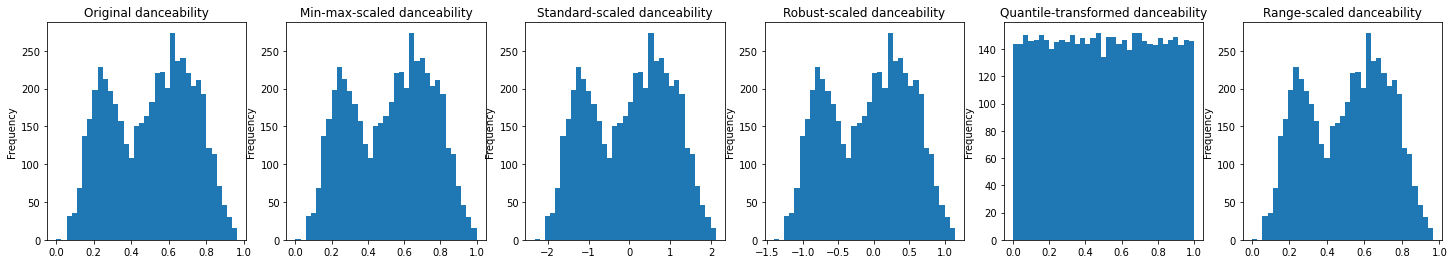

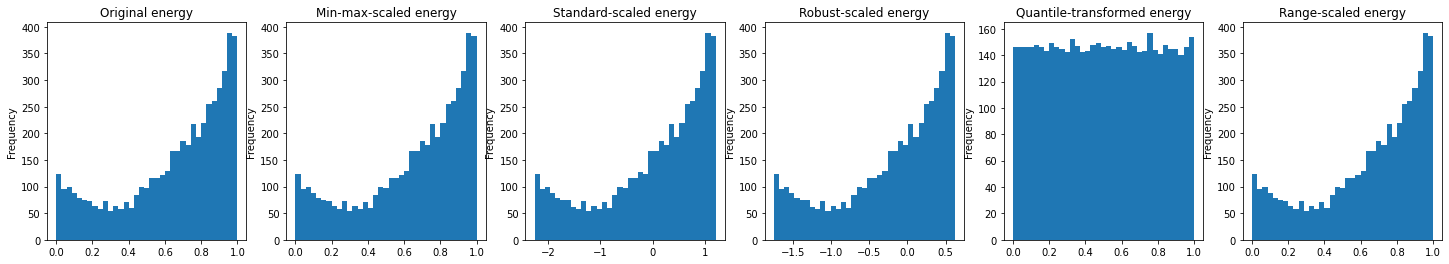

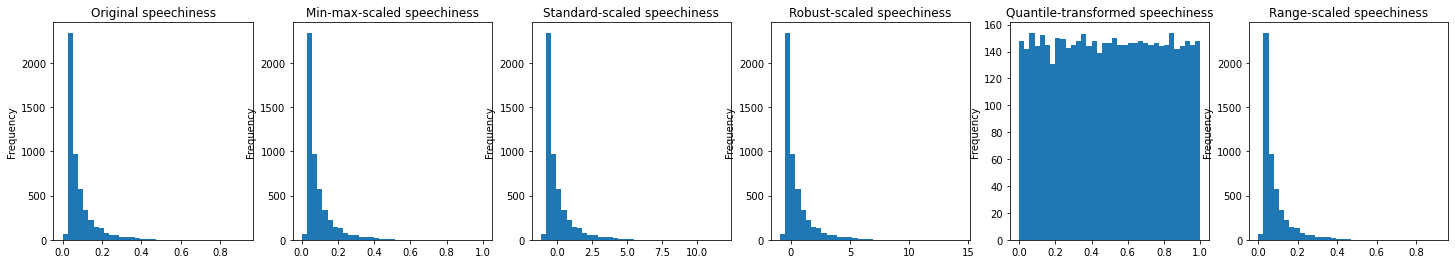

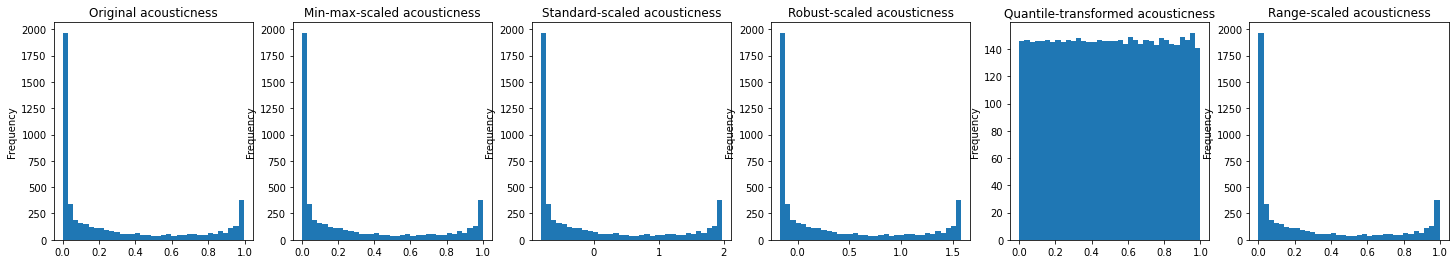

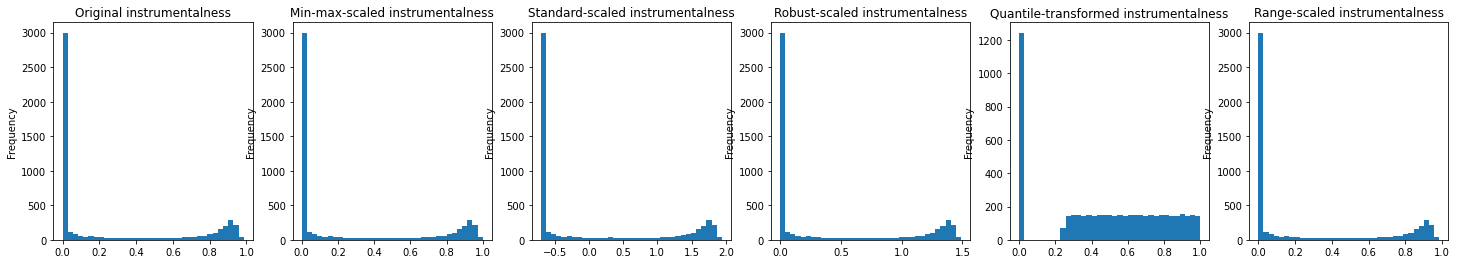

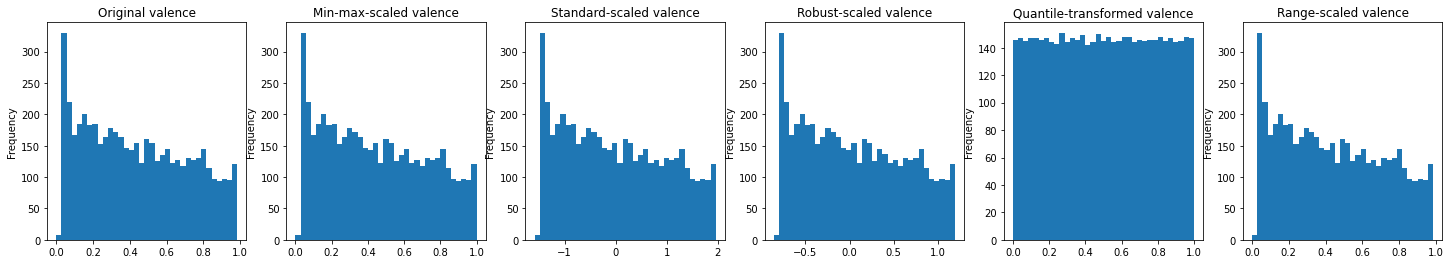

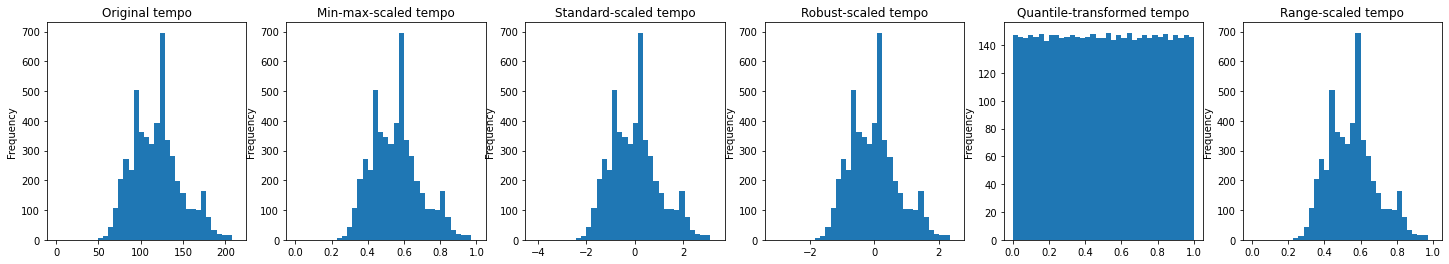

In [12]:
# loop through each relevant column to compare distributions

for var in cols:
    plt.figure(figsize=(25, 4))
    
    # plot original data
    plt.subplot(1, 6, 1)
    features_big[var].plot.hist(bins=35)
    plt.title(f"Original {var}")
    
    # plot min-max scaled data
    plt.subplot(1, 6, 2)
    min_max_scaled[var].plot.hist(bins=35)
    plt.title(f"Min-max-scaled {var}")

    # plot standard scaled data
    plt.subplot(1, 6, 3)
    standard_scaled[var].plot.hist(bins=35)
    plt.title(f"Standard-scaled {var}")

    # plot robust scaled data
    plt.subplot(1, 6, 4)
    robust_scaled[var].plot.hist(bins=35)
    plt.title(f"Robust-scaled {var}")

    # plot quantile transformed data
    plt.subplot(1, 6, 5)
    quantile_transformed[var].plot.hist(bins=35)
    plt.title(f"Quantile-transformed {var}")

     # plot range-scaled data
    plt.subplot(1, 6, 6)
    range_scaled[var].plot.hist(bins=35)
    plt.title(f"Range-scaled {var}")
    
    # show all plots
    plt.show()

### Decision on scaling method

For now, range-scaling is used for variables that already have a range of [0,1] and min-max-scaling is used for variables that don't have a set range.

## Find best k

In [13]:
def find_best_k(data, min_n_clusters, max_n_clusters):
    inertia_values = []
    silhouette_scores = []
    n_clusters = range(min_n_clusters, max_n_clusters + 1)

    for n in n_clusters:
        kmeans = KMeans(n_clusters= n)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    plt.subplots(figsize = (25,10))

    plt.subplot(1,2,1)
    plt.plot(n_clusters, inertia_values, 'bx-')
    plt.xticks(n_clusters)
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Elbow Method For Optimal k')

    plt.subplot(1,2,2)
    plt.plot(n_clusters, silhouette_scores, 'bx-')
    plt.xticks(n_clusters)
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.title('Silhouette Scores For Optimal k')

    plt.show()

Range scaled:


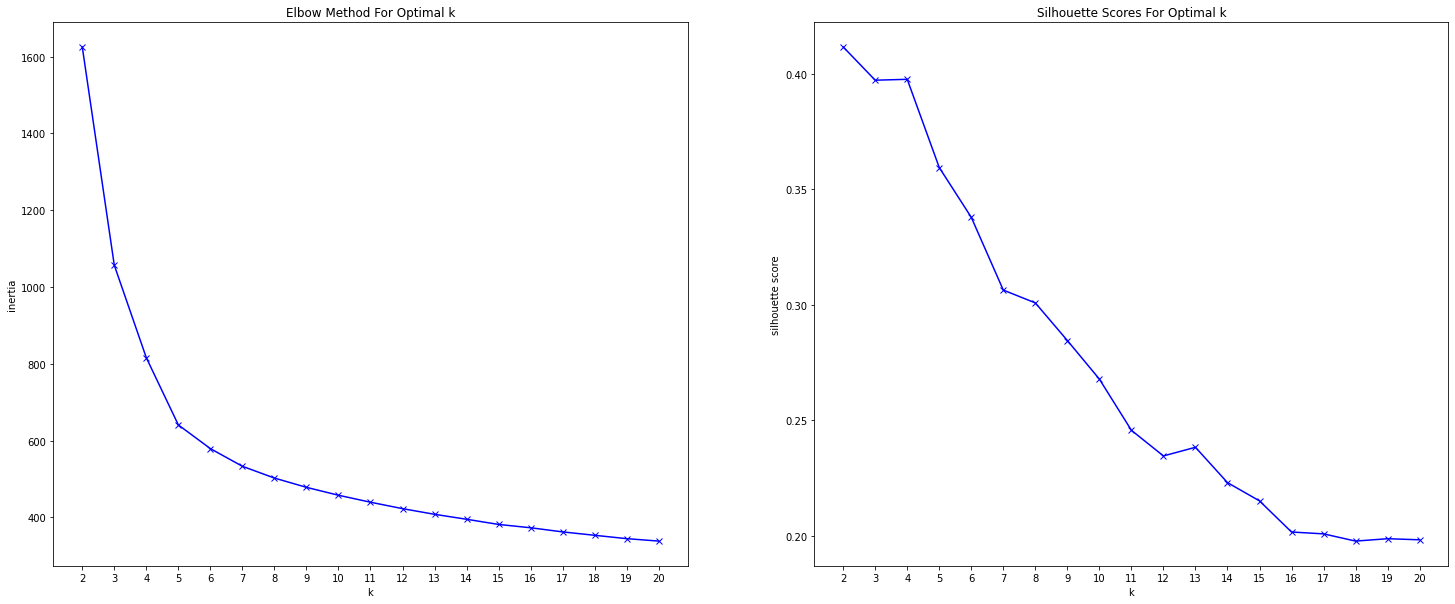

Min-max scaled:


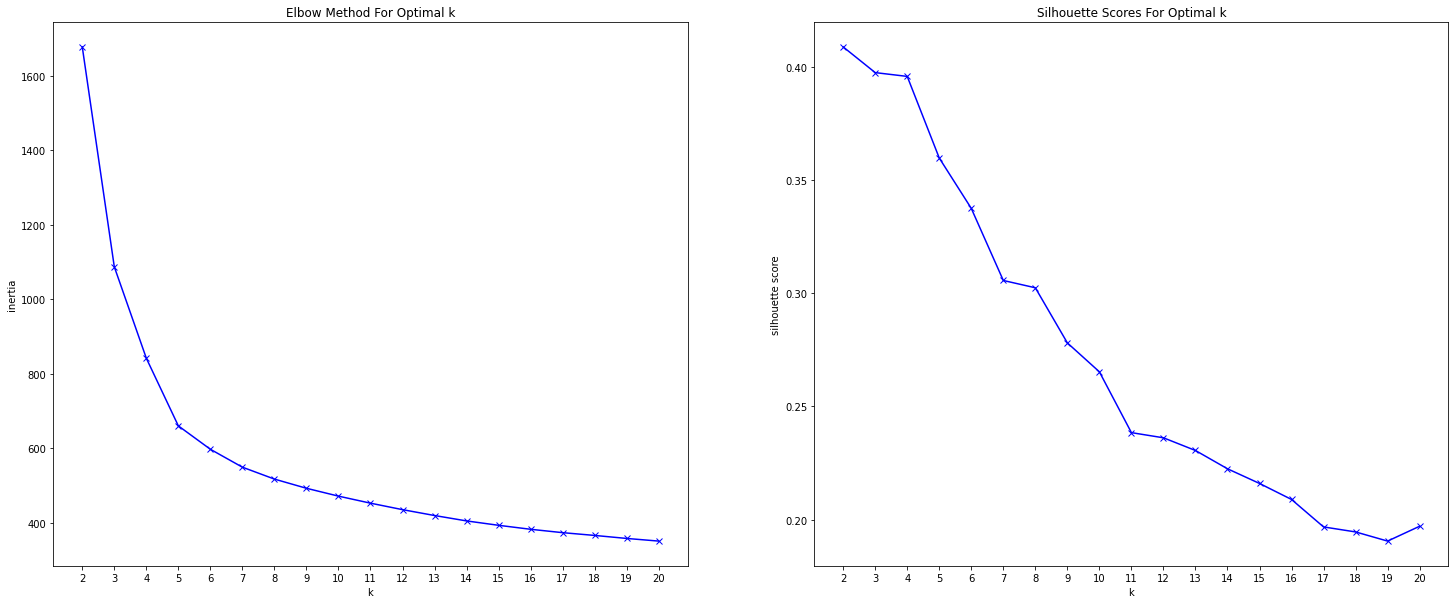

Standard scaled:


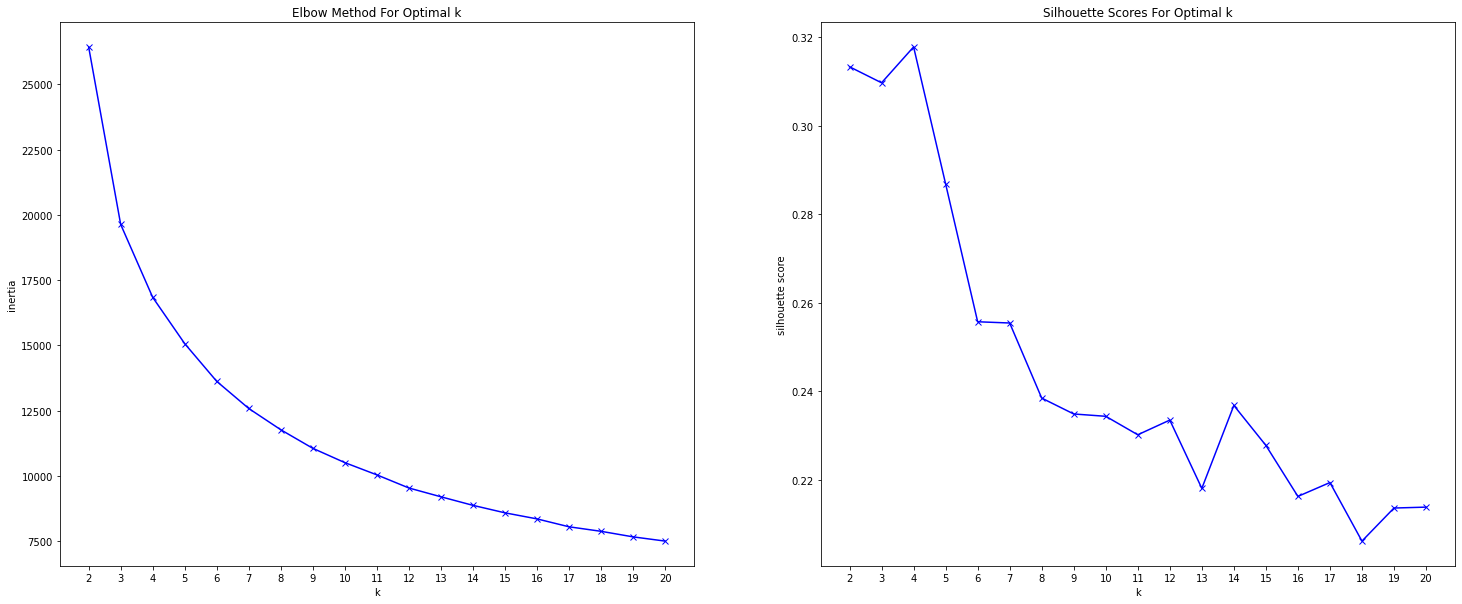

Robust scaled:


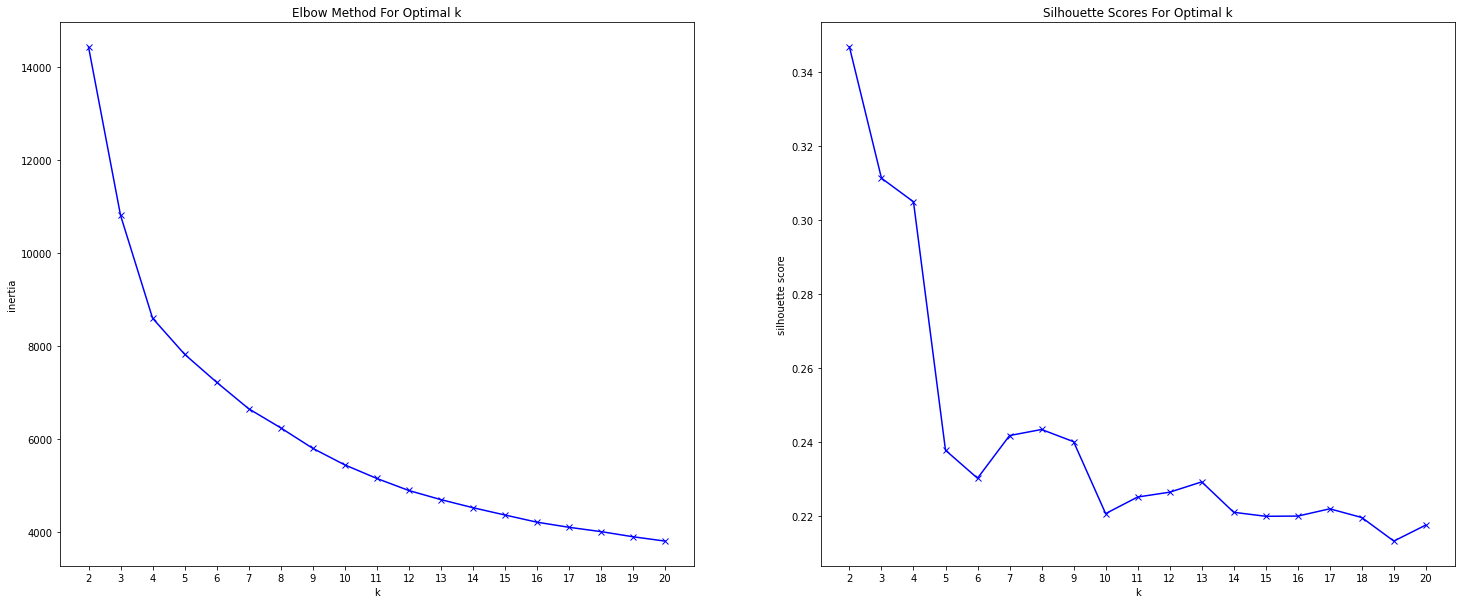

Quantile transformed:


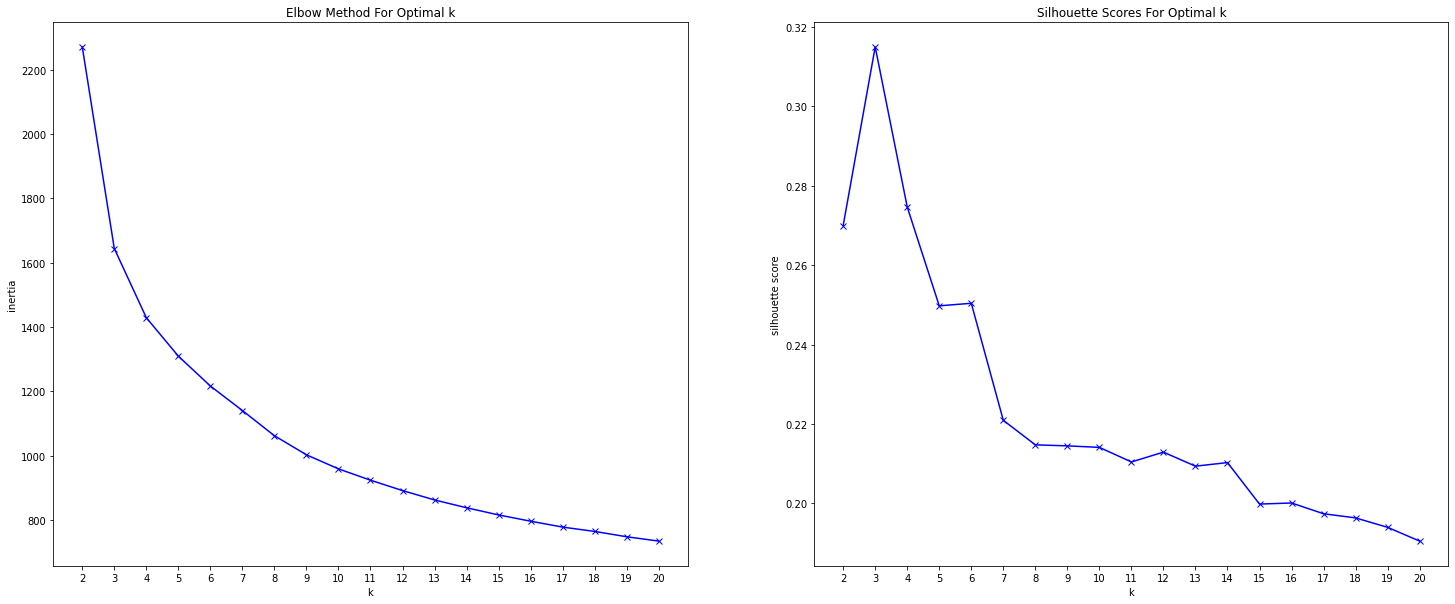

In [14]:
print('Range scaled:')
find_best_k(range_scaled, 2, 20)

print('Min-max scaled:')
find_best_k(min_max_scaled, 2, 20)

print('Standard scaled:')
find_best_k(standard_scaled, 2, 20)

print('Robust scaled:')
find_best_k(robust_scaled, 2, 20)

print('Quantile transformed:')
find_best_k(quantile_transformed, 2, 20)

### Decision on k-value

* elbow plot is ambiguous - could be a value between 5-7 roughly
* silhouette plot has local maximum at k = 6
* based on these two sources a final k of 6 is chosen 

## Conduct clustering and explore results

### Create clusters

In [15]:
# initialize the clusters
kmeans = KMeans(n_clusters= 5)

# fit the clusters to the data
kmeans.fit(range_scaled) 

# obtain the cluster output
clusters = kmeans.predict(range_scaled)
clusters_df = pd.DataFrame({'name': features_big['name'], 'cluster': clusters})

# get centroids
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids)
centroids_df.columns = range_scaled.columns

# add the cluster output to the dataframes
scaled_clustered = range_scaled.copy()
scaled_clustered['cluster'] = clusters
features_big['cluster'] = clusters

# create reindex scaled clustered df for calculating the distance
# this avoids problems with using the name as the index as there are duplicate names
scaled_clustered_reindexed = scaled_clustered.reset_index().copy()

### Find the most fitting songs by taking the 30 songs that are closest to their respective centroid per cluster 

In [27]:
def calculate_euclidian_distance():
    euclidian_distances = []

    for row in scaled_clustered_reindexed.iterrows():
        distances = []
        for col in centroids_df.columns:
            centroid = row[1]['cluster']
            distances.append((scaled_clustered_reindexed[col][row[0]] - centroids_df[col][centroid]) ** 2)
        euclidian_distances.append(sum(distances) ** 0.5)

    return euclidian_distances

In [28]:
# get distances and create a new df with results
scaled_clustered['euclidian_distance_to_centroid'] = calculate_euclidian_distance()
title_distance = scaled_clustered[['euclidian_distance_to_centroid', 'cluster']].copy()
title_distance['euclidian_distance_to_centroid'] = title_distance['euclidian_distance_to_centroid'].astype(float)

In [23]:
title_distance.loc[title_distance.index == 'I Will Always Love You',:]

,euclidian_distance_to_centroid,cluster
name,,
I Will Always Love You,name I Will Always Love You 0.448777 I Will...,2
I Will Always Love You,name I Will Always Love You 0.448777 I Will...,2
I Will Always Love You,name I Will Always Love You 0.879524 I Will...,4


In [20]:
title_distance.index.value_counts()

Chandelier                               3
I Will Always Love You                   3
Perfect                                  3
Wake Me Up                               3
Summertime                               3
                                        ..
Comptine d'un autre été: L'après-midi    1
Bylur                                    1
Adagio for Strings and Organ             1
To the Sky (Moderate)                    1
Ravel: Boléro, M. 81                     1
Name: name, Length: 5011, dtype: int64

In [52]:
# extract the 30 songs with the lowest distance to their centroid from each cluster

cluster_song_lists = []

for cluster in title_distance.cluster.unique():
    top30_song_list = title_distance.query("cluster == @cluster").sort_values('euclidian_distance_to_centroid')#.head(30)
    # cluster_song_lists.append(top30_song_list.index.tolist())

# top30_df = pd.DataFrame()
# for nr, song_list in enumerate(cluster_song_lists):
#     print(nr, song_list)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [24]:
cluster_song_lists[0]

[]

### Explore clusters to find labels

In [77]:
(
    features_big
        [['danceability', 'energy', 'loudness',
        'speechiness', 'instrumentalness', 
        'valence', 'tempo', 'cluster']]
        .groupby(by= 'cluster')
        .mean()
)

,danceability,energy,loudness,speechiness,instrumentalness,valence,tempo
cluster,,,,,,,
0,0.355893,0.172557,-16.432961,0.044300,0.047156,0.213039,104.576889
1,0.713065,0.700960,-6.901071,0.068940,0.033283,0.780755,120.779118
2,0.510786,0.745252,-6.112597,0.083950,0.089199,0.340166,132.923853
3,0.768772,0.675067,-6.453907,0.277602,0.015769,0.605025,109.442414
4,0.589845,0.457942,-10.330848,0.064019,0.038310,0.625278,116.152357
5,0.279225,0.158455,-20.839510,0.043585,0.834533,0.147830,102.314897


In [ ]:
features_big.groupby(by = 'cluster').agg(count = ('name', 'count'))

### Cluster Labels
- 0 = ?
- 1 = ?
- 2 = ?
- 3 = ?
- 4 = ?
- 5 = ?
- 6 = ?